### Libraries

In [1]:
import contextily as cx
from ipywidgets import interact
from math import floor
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from pyrsgis import raster
from pyrsgis.convert import array_to_table
from pyrsgis.ml import imageChipsFromArray
import random
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential

### Loading the multispectral image

In [2]:
# file names
feature_file = './BrokenHill_ASTER.tif'

# read the image
dsFeatures, arrFeatures = raster.read(feature_file, bands='all')
arrFeatures = arrFeatures.astype(float)
# arrFeatures = np.float16(arrFeatures)

# dsFeatures.__dict__

min_x = dsFeatures.bbox[0][0]
max_x = dsFeatures.bbox[1][0]
min_y = dsFeatures.bbox[0][1]
max_y = dsFeatures.bbox[1][1]

extent = [min_x, max_x, min_y, max_y]

### Visualizing spectral bands

In [3]:
def plot_array_stretched(array, label, n):
    fig, ax = plt.subplots(figsize=(10, 10))
    v_mean = np.array(np.nanmean(array))
    v_std = np.array(np.nanstd(array))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(array, cmap='Greys_r', extent=extent, vmin=v_mean-(n*v_std), vmax=v_mean+(n*v_std))
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label=label, cax=cax)
    plt.grid(False)
    plt.show()

def plot_array(array, label):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(array, cmap='Greys_r', extent=extent)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label=label, cax=cax)
    plt.grid(False)
    plt.show()

@interact(band=range(1, arrFeatures.shape[0]+1))
def show_dist(band):
    plot_array_stretched(arrFeatures[band-1, :, :], f'Band {band}', 3)

interactive(children=(Dropdown(description='band', options=(1, 2, 3, 4, 5, 6, 7, 8, 9), value=1), Output()), _…

### Normalizing

In [4]:
arrFeatures = array_to_table(arrFeatures)
arrFeatures_fuzzy = np.zeros(arrFeatures.shape)

# normalize the image
for i in range(arrFeatures.shape[1]):
    bandMin = arrFeatures[:, i].min()
    bandMax = arrFeatures[:, i].max()
    bandRange = bandMax-bandMin
    for j in range(arrFeatures.shape[0]):
        arrFeatures_fuzzy[j, i] = (arrFeatures[j, i]-bandMin)/bandRange

### Loading the training dataset (manual)

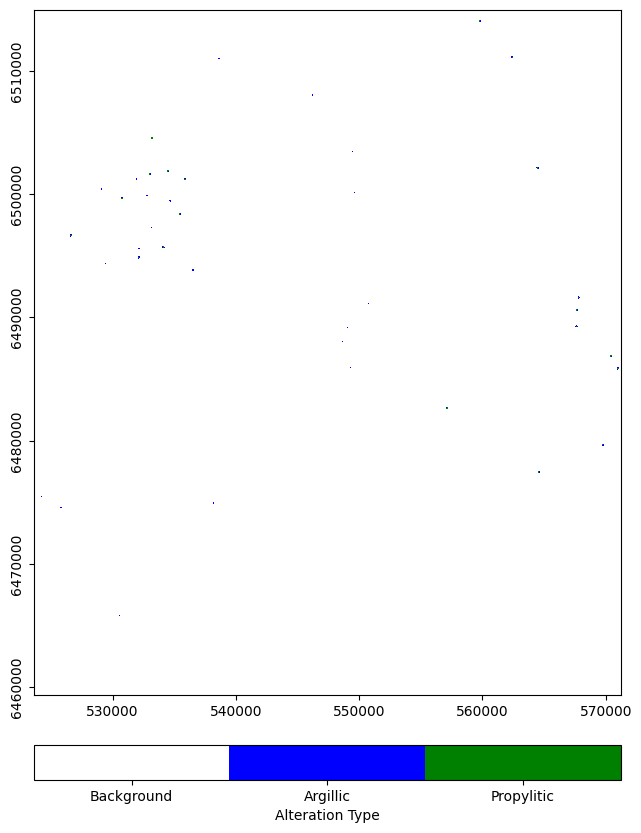

In [5]:
positiveLabel_file = './BrokenHill_ASTER_Manual_CombinedTraining.tif'
# read and reshape the label file
dsPositiveLabels, arrPositiveLabels = raster.read(positiveLabel_file)
n_class_pos = len(np.unique(arrPositiveLabels))

fig, ax = plt.subplots(figsize=(10, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['white', 'blue', 'green'])
image = plt.imshow(arrPositiveLabels, cmap=cmap, extent=extent)
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos) + 0.5)*(n_class_pos-1)/n_class_pos
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Background', 'Argillic', 'Propylitic'])
plt.grid(False)

### Generating random samples

In [6]:
# generate random samples
nonZero_count = np.count_nonzero(arrPositiveLabels)
index = np.transpose(np.where(arrPositiveLabels==0))
index = index.astype(int)
randomIndex = random.sample(range(index.shape[0]), int(nonZero_count/(n_class_pos-1)))
arrNegativeLabels = np.zeros(arrPositiveLabels.shape)

for i in range(len(randomIndex)):
    arrNegativeLabels[index[randomIndex[i], 0], index[randomIndex[i], 1]] = n_class_pos # max value of labels plus one which equals n_class
    
arrPositiveLabels_flat = arrPositiveLabels.flatten()
arrNegativeLabels_flat = arrNegativeLabels.flatten()
# separate and balance the classes
positiveFeatures = arrFeatures_fuzzy[arrPositiveLabels_flat!=0]
positiveLabels = arrPositiveLabels_flat[arrPositiveLabels_flat!=0]
negativeFeatures = arrFeatures_fuzzy[arrNegativeLabels_flat==n_class_pos]
negativeLabels = arrNegativeLabels_flat[arrNegativeLabels_flat==n_class_pos]
# combine the balanced features
features = np.concatenate((positiveFeatures, negativeFeatures), axis=0)
labels = np.concatenate((positiveLabels, negativeLabels), axis=0)
labels[labels==n_class_pos] = 0
# call the function to split the dataset
train_x, train_y, test_x, test_y = train_test_split(features, labels, train_size=0.7)

### Training the model using MLP

In [7]:
# create the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(8, activation='selu', input_shape=(train_x.shape[1], )))
model.add(tf.keras.layers.Dense(6, activation='selu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

# print(model.summary())

# run the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(train_x, test_x, epochs=80)
# predict for the test dataset
yTestPredicted = model.predict(train_y)
# calculate and display error metrics
yTestPredicted_ = yTestPredicted.argmax(axis=1)

cMatrix = confusion_matrix(test_y, yTestPredicted_)
pScore = precision_score(test_y, yTestPredicted_, average='micro')
rScore = recall_score(test_y, yTestPredicted_, average='micro')
fscore = f1_score(test_y, yTestPredicted_, average='micro')

print("Confusion matrix:\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f, F-Score: %.3f" % (pScore, rScore, fscore))

Epoch 1/80
134/134 [==============================] - 1s 2ms/step - loss: 1.1235 - accuracy: 0.3824
Epoch 2/80
134/134 [==============================] - 0s 2ms/step - loss: 1.0455 - accuracy: 0.5442
Epoch 3/80
134/134 [==============================] - 0s 2ms/step - loss: 0.9960 - accuracy: 0.6420
Epoch 4/80
134/134 [==============================] - 0s 2ms/step - loss: 0.9397 - accuracy: 0.6782
Epoch 5/80
134/134 [==============================] - 0s 2ms/step - loss: 0.8564 - accuracy: 0.7108
Epoch 6/80
134/134 [==============================] - 0s 2ms/step - loss: 0.7908 - accuracy: 0.7321
Epoch 7/80
134/134 [==============================] - 0s 2ms/step - loss: 0.7300 - accuracy: 0.7441
Epoch 8/80
134/134 [==============================] - 0s 2ms/step - loss: 0.6816 - accuracy: 0.7560
Epoch 9/80
134/134 [==============================] - 0s 2ms/step - loss: 0.6419 - accuracy: 0.7596
Epoch 10/80
134/134 [==============================] - 0s 2ms/step - loss: 0.6088 - accuracy: 0.7696

### Mapping alteration zones

367904/367904 [==============================] - 437s 1ms/step


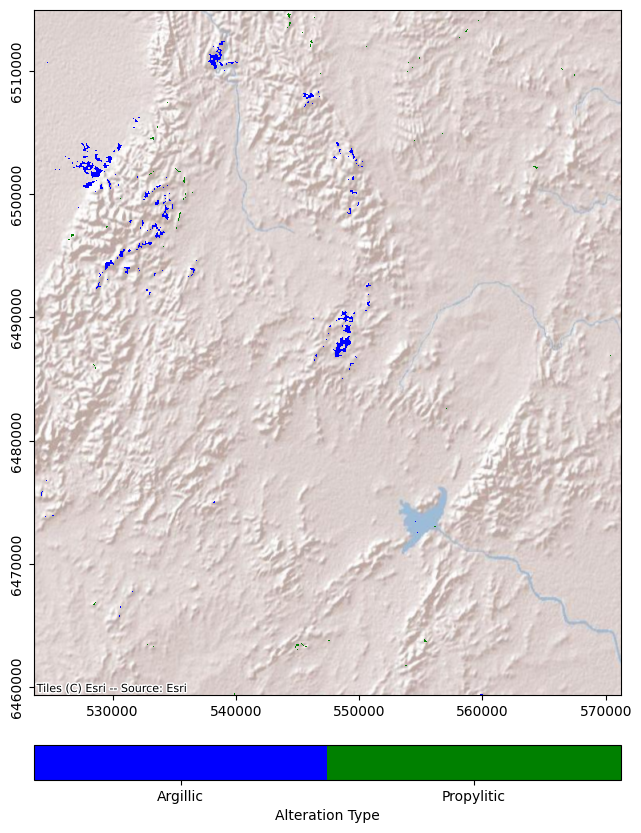

In [8]:
# load and normalize a new multispectral image
dsPred, arrPred = raster.read('./BrokenHill_ASTER.tif')
arrPred = arrPred.astype(float)
# arrPred = np.float16(arrPred)
arrPred = array_to_table(arrPred)
arrPred_fuzzy = np.zeros(arrPred.shape)

# normalize the image
for i in range(arrPred.shape[1]):
    bandMin = arrPred[:, i].min()
    bandMax = arrPred[:, i].max()
    bandRange = bandMax-bandMin
    for j in range(arrPred.shape[0]):
        arrPred_fuzzy[j, i] = (arrPred[j, i]-bandMin)/bandRange

# predict and export the probability raster
pred = model.predict(arrPred_fuzzy)
pred_array = np.reshape(pred.argmax(axis=1), (dsPred.RasterYSize, dsPred.RasterXSize))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'green'])

pred_array_copy = pred_array.copy()
pred_array_copy = pred_array_copy.astype('float')
pred_array_copy[pred_array_copy==0] = float('nan')
image = plt.imshow(pred_array_copy, cmap=cmap, extent=extent)

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Propylitic'])
plt.grid(False)

# outFile = './BrokenHill_ASTER_Manual_MLP_AlterationMap.tif'
# raster.export(pred_array, dsPred, filename=outFile, dtype='float')

### Training the model using SVM

In [9]:
model = SVC()
model.fit(train_x, test_x)
# predict for the test dataset
yTestPredicted = model.predict(train_y)
# # calculate and display error metrics
# yTestPredicted_ = yTestPredicted.argmax(axis=1)

cMatrix = confusion_matrix(test_y, yTestPredicted)
pScore = precision_score(test_y, yTestPredicted, average='micro')
rScore = recall_score(test_y, yTestPredicted, average='micro')
fscore = f1_score(test_y, yTestPredicted, average='micro')

print("Confusion matrix:\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f, F-Score: %.3f" % (pScore, rScore, fscore))

Confusion matrix:
 [[599   0   2]
 [  0 635  10]
 [ 17   9 555]]

P-Score: 0.979, R-Score: 0.979, F-Score: 0.979


### Mapping alteration zones

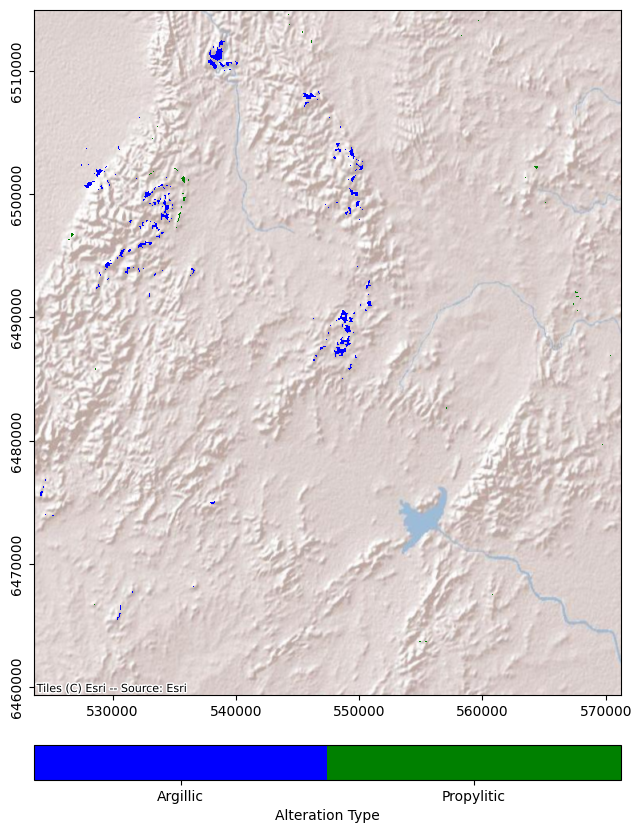

In [10]:
# load and normalize a new multispectral image
dsPred, arrPred = raster.read('./BrokenHill_ASTER.tif')
arrPred = arrPred.astype(float)
# arrPred = np.float16(arrPred)
arrPred = array_to_table(arrPred)
arrPred_fuzzy = np.zeros(arrPred.shape)

# normalize the image
for i in range(arrPred.shape[1]):
    bandMin = arrPred[:, i].min()
    bandMax = arrPred[:, i].max()
    bandRange = bandMax-bandMin
    for j in range(arrPred.shape[0]):
        arrPred_fuzzy[j, i] = (arrPred[j, i]-bandMin)/bandRange

# predict and export the probability raster
pred = model.predict(arrPred_fuzzy)
pred_array = np.reshape(pred, (dsPred.RasterYSize, dsPred.RasterXSize))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'green'])

pred_array_copy = pred_array.copy()
pred_array_copy = pred_array_copy.astype('float')
pred_array_copy[pred_array_copy==0] = float('nan')
image = plt.imshow(pred_array_copy, cmap=cmap, extent=extent)

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Propylitic'])
plt.grid(False)

# outFile = './BrokenHill_ASTER_Manual_SVM_AlterationMap.tif'
# raster.export(pred_array, dsPred, filename=outFile, dtype='float')

### Loading the training dataset (PCA)

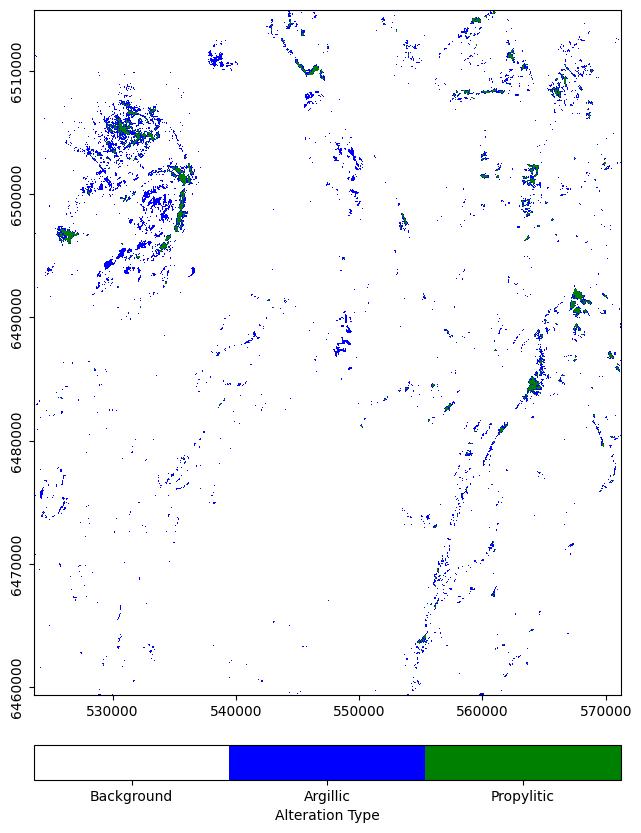

In [11]:
positiveLabel_file = './BrokenHill_ASTER_PCA_CombinedTraining.tif'
# read and reshape the label file
dsPositiveLabels, arrPositiveLabels = raster.read(positiveLabel_file)
n_class_pos = len(np.unique(arrPositiveLabels))

fig, ax = plt.subplots(figsize=(10, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['white', 'blue', 'green'])
image = plt.imshow(arrPositiveLabels, cmap=cmap, extent=extent)
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos) + 0.5)*(n_class_pos-1)/n_class_pos
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Background', 'Argillic', 'Propylitic'])
plt.grid(False)

### Generating random samples

In [12]:
# generate random samples
nonZero_count = np.count_nonzero(arrPositiveLabels)
index = np.transpose(np.where(arrPositiveLabels==0))
index = index.astype(int)
randomIndex = random.sample(range(index.shape[0]), int(nonZero_count/(n_class_pos-1)))
arrNegativeLabels = np.zeros(arrPositiveLabels.shape)

for i in range(len(randomIndex)):
    arrNegativeLabels[index[randomIndex[i], 0], index[randomIndex[i], 1]] = n_class_pos # max value of labels plus one which equals n_class
    
arrPositiveLabels_flat = arrPositiveLabels.flatten()
arrNegativeLabels_flat = arrNegativeLabels.flatten()
# separate and balance the classes
positiveFeatures = arrFeatures_fuzzy[arrPositiveLabels_flat!=0]
positiveLabels = arrPositiveLabels_flat[arrPositiveLabels_flat!=0]
negativeFeatures = arrFeatures_fuzzy[arrNegativeLabels_flat==n_class_pos]
negativeLabels = arrNegativeLabels_flat[arrNegativeLabels_flat==n_class_pos]
# combine the balanced features
features = np.concatenate((positiveFeatures, negativeFeatures), axis=0)
labels = np.concatenate((positiveLabels, negativeLabels), axis=0)
labels[labels==n_class_pos] = 0
# call the function to split the dataset
train_x, train_y, test_x, test_y = train_test_split(features, labels, train_size=0.7)

### Training the model using MLP

In [13]:
# create the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(8, activation='selu', input_shape=(train_x.shape[1], )))
model.add(tf.keras.layers.Dense(6, activation='selu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

# print(model.summary())

# run the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(train_x, test_x, epochs=40)
# predict for the test dataset
yTestPredicted = model.predict(train_y)
# calculate and display error metrics
yTestPredicted_ = yTestPredicted.argmax(axis=1)

cMatrix = confusion_matrix(test_y, yTestPredicted_)
pScore = precision_score(test_y, yTestPredicted_, average='micro')
rScore = recall_score(test_y, yTestPredicted_, average='micro')
fscore = f1_score(test_y, yTestPredicted_, average='micro')

print("Confusion matrix:\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f, F-Score: %.3f" % (pScore, rScore, fscore))

Epoch 1/40
12873/12873 [==============================] - 30s 2ms/step - loss: 0.3709 - accuracy: 0.8437
Epoch 2/40
12873/12873 [==============================] - 34s 3ms/step - loss: 0.1350 - accuracy: 0.9516
Epoch 3/40
12873/12873 [==============================] - 34s 3ms/step - loss: 0.1134 - accuracy: 0.9602
Epoch 4/40
12873/12873 [==============================] - 34s 3ms/step - loss: 0.1015 - accuracy: 0.9651
Epoch 5/40
12873/12873 [==============================] - 34s 3ms/step - loss: 0.0947 - accuracy: 0.9678
Epoch 6/40
12873/12873 [==============================] - 33s 3ms/step - loss: 0.0899 - accuracy: 0.9695
Epoch 7/40
12873/12873 [==============================] - 35s 3ms/step - loss: 0.0863 - accuracy: 0.9707
Epoch 8/40
12873/12873 [==============================] - 34s 3ms/step - loss: 0.0846 - accuracy: 0.9716
Epoch 9/40
12873/12873 [==============================] - 30s 2ms/step - loss: 0.0834 - accuracy: 0.9720
Epoch 10/40
12873/12873 [==============================

### Mapping alteration zones

367904/367904 [==============================] - 362s 983us/step


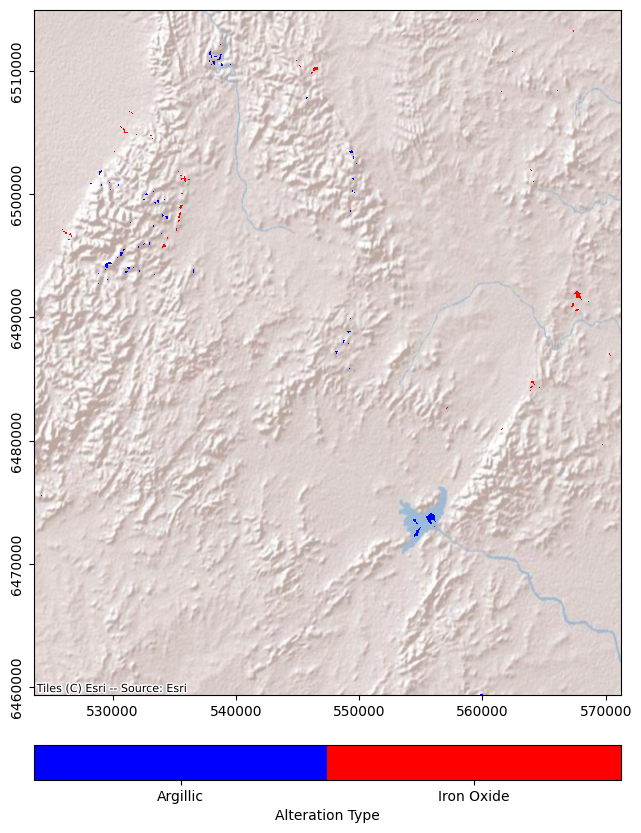

In [14]:
# load and normalize a new multispectral image
dsPred, arrPred = raster.read('./BrokenHill_ASTER.tif')
arrPred = arrPred.astype(float)
# arrPred = np.float16(arrPred)
arrPred = array_to_table(arrPred)
arrPred_fuzzy = np.zeros(arrPred.shape)

# normalize the image
for i in range(arrPred.shape[1]):
    bandMin = arrPred[:, i].min()
    bandMax = arrPred[:, i].max()
    bandRange = bandMax-bandMin
    for j in range(arrPred.shape[0]):
        arrPred_fuzzy[j, i] = (arrPred[j, i]-bandMin)/bandRange

# predict and export the probability raster
pred = model.predict(arrPred_fuzzy)
pred_array = np.reshape(pred.argmax(axis=1), (dsPred.RasterYSize, dsPred.RasterXSize))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'green'])

pred_array_copy = pred_array.copy()
pred_array_copy = pred_array_copy.astype('float')
pred_array_copy[pred_array_copy==0] = float('nan')
image = plt.imshow(pred_array_copy, cmap=cmap, extent=extent)

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Propylitic'])
plt.grid(False)

# outFile = './BrokenHill_Landsat8_PCA_MLP_AlterationMap.tif'
# raster.export(pred_array, dsPred, filename=outFile, dtype='float')

### Training the model using SVM

In [15]:
model = SVC()
model.fit(train_x, test_x)
# predict for the test dataset
yTestPredicted = model.predict(train_y)
# calculate and display error metrics
cMatrix = confusion_matrix(test_y, yTestPredicted)
pScore = precision_score(test_y, yTestPredicted, average='micro')
rScore = recall_score(test_y, yTestPredicted, average='micro')
fscore = f1_score(test_y, yTestPredicted, average='micro')

print("Confusion matrix:\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f, F-Score: %.3f" % (pScore, rScore, fscore))

Confusion matrix:
 [[32374     3     0]
 [   29 85132     0]
 [  472  1584 56943]]

P-Score: 0.988, R-Score: 0.988, F-Score: 0.988


### Mapping alteration zones

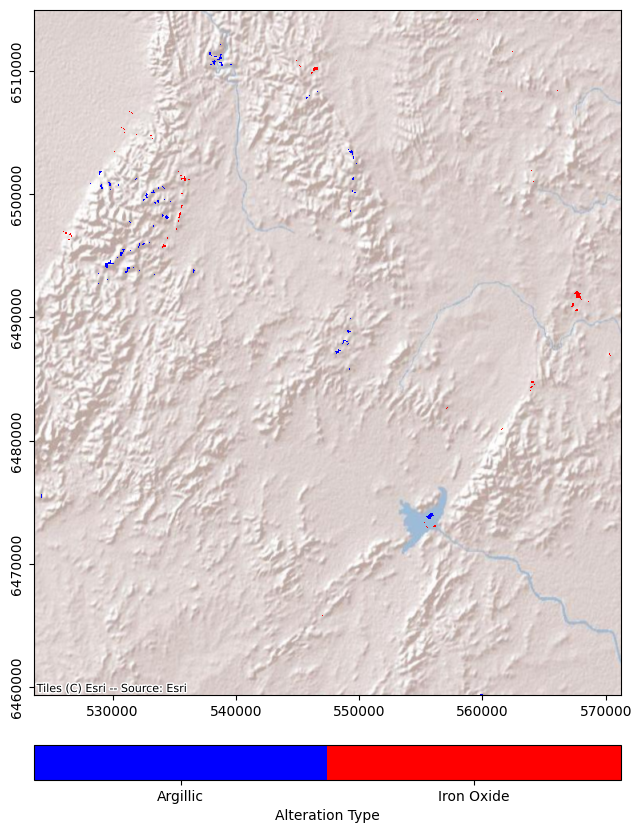

In [16]:
# load and normalize a new multispectral image
dsPred, arrPred = raster.read('./BrokenHill_ASTER.tif')
arrPred = arrPred.astype(float)
# arrPred = np.float16(arrPred)
arrPred = array_to_table(arrPred)
arrPred_fuzzy = np.zeros(arrPred.shape)

# normalize the image
for i in range(arrPred.shape[1]):
    bandMin = arrPred[:, i].min()
    bandMax = arrPred[:, i].max()
    bandRange = bandMax-bandMin
    for j in range(arrPred.shape[0]):
        arrPred_fuzzy[j, i] = (arrPred[j, i]-bandMin)/bandRange

# predict and export the probability raster
pred = model.predict(arrPred_fuzzy)
pred_array = np.reshape(pred, (dsPred.RasterYSize, dsPred.RasterXSize))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'green'])

pred_array_copy = pred_array.copy()
pred_array_copy = pred_array_copy.astype('float')
pred_array_copy[pred_array_copy==0] = float('nan')
image = plt.imshow(pred_array_copy, cmap=cmap, extent=extent)

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Propylitic'])
plt.grid(False)

# outFile = './BrokenHill_Landsat8_PCA_SVM_AlterationMap.tif'
# raster.export(pred_array, dsPred, filename=outFile, dtype='float')